# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [3]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-05-14/data_eval_new/"
file_name = "int_norm_20160514_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [4]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [6]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

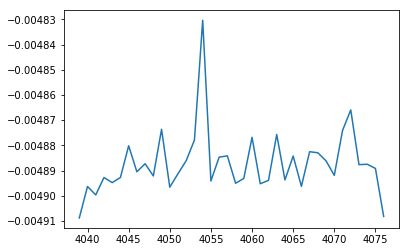

In [11]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

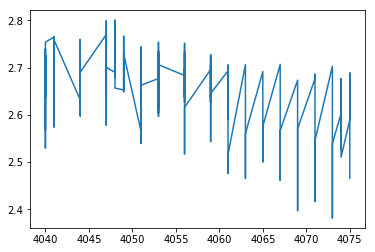

In [12]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [13]:
df_mean(signals[signals["Sample"] != "blank sol"])["Sample"].unique()

array(['NIST 200ppb', 'NIST 350ppb', 'NIST 200ppb + 0.02ppb Mo',
       'NIST 200ppb + 0.6ppb Pd', 'NIST 200ppb + 0.03ppb Cd',
       'NIST 200ppb + 0.005ppb U'], dtype=object)

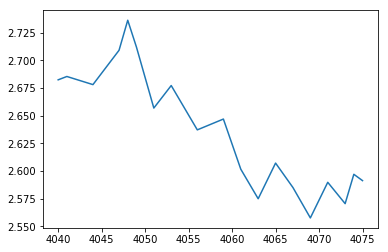

In [14]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

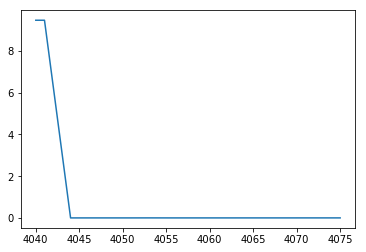

In [15]:
# Check background 
column = "120"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [23]:
background = background.drop([pd.Timestamp("2016-05-14 12:13:00"), pd.Timestamp("2016-05-14 12:25:00")])

In [24]:
background_mean = df_mean(background)

In [25]:
# Create Dataframe for signals_bgd corr
signals["Te/Sn"] = (signals["125_2"]/7.050686)/(signals["118"]/24.223)
signals["Cd/Sn"] = (signals["111"]/12.9447)/(signals["118"]/24.223)

In [26]:
signals_mean = signals.groupby("Filenumber").agg("mean")

# Outlier rejection

In [190]:
bgd_method = 'bgd_outlier_corr' #'no_bgd_corr'
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [191]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [196]:
column = "124/118"
sample = "NIST 200ppb"

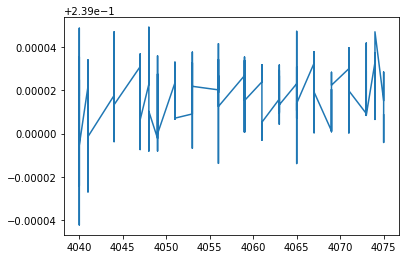

In [197]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [198]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [199]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2016-05-14 12:13:00,NIST 200ppb,2,1,4040,0.040137,0.027187,0.013945,0.600267,0.316695,0.354606,1.345821,0.19125,0.239018
2016-05-14 12:13:00,NIST 200ppb,2,2,4040,0.040137,0.027169,0.013946,0.600286,0.316709,0.354608,1.345877,0.19125,0.239025
2016-05-14 12:13:00,NIST 200ppb,2,3,4040,0.040118,0.027157,0.013938,0.600249,0.316700,0.354586,1.345854,0.19125,0.238958
2016-05-14 12:13:00,NIST 200ppb,2,4,4040,0.040123,0.027161,0.013949,0.600351,0.316708,0.354644,1.345866,NaN,0.238999
2016-05-14 12:13:00,NIST 200ppb,2,5,4040,0.040127,0.027163,0.013946,0.600331,0.316698,0.354658,1.345708,0.19125,0.238974
2016-05-14 12:13:00,NIST 200ppb,2,6,4040,0.040127,0.027149,0.013946,0.600296,0.316689,0.354621,1.345941,0.19125,0.239007
2016-05-14 12:13:00,NIST 200ppb,2,7,4040,0.040135,0.027160,0.013944,0.600317,0.316708,0.354583,1.345867,0.19125,0.238958
2016-05-14 12:13:00,NIST 200ppb,2,8,4040,0.040131,0.027166,0.013952,0.600337,0.316692,0.354625,1.345929,0.19125,0.239001
2016-05-14 12:13:00,NIST 200ppb,2,9,4040,0.040131,0.027165,0.013944,0.600318,0.316727,0.354641,1.345949,0.19125,0.239033


In [200]:
df_outlier_int[df_outlier_int[column].notnull()][column]

Filenumber  Date               
4044        2016-05-14 13:07:00    0.239047
4045        2016-05-14 13:20:00    0.239037
4060        2016-05-14 16:29:00    0.239032
4065        2016-05-14 17:35:00    0.239047
            2016-05-14 17:35:00    0.238986
Name: 124/118, dtype: float64

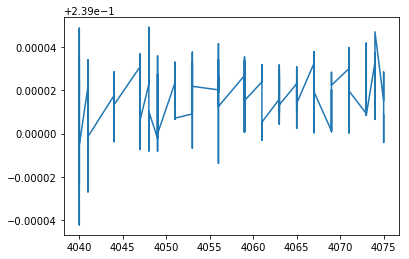

In [201]:
# Check sample measurements
df = df_outlier_rej_int

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [202]:
df[df["Sample"] == sample][column].std()

1.2777316683158206e-05

In [203]:
df_outlier_rej_int["Cd/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Cd/Sn"]
df_outlier_rej_int["Te/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Te/Sn"]

In [204]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

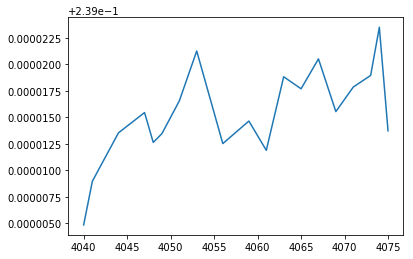

In [205]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [206]:
data_mean_int

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Cd/Sn,Te/Sn
Date,,,,,,,,,,,,,
2016-05-14 12:13:00,4040,NIST 200ppb,0.040125,0.027160,0.013946,0.600304,0.316707,0.354616,1.345898,0.19125,0.239005,0.000147,0.000031
2016-05-14 12:25:00,4041,NIST 200ppb,0.040135,0.027169,0.013947,0.600327,0.316712,0.354628,1.345924,0.19125,0.239009,0.000144,0.000039
2016-05-14 13:07:00,4044,NIST 200ppb,0.040133,0.027172,0.013945,0.600291,0.316708,0.354608,1.345930,0.19125,0.239014,0.000139,0.000037
2016-05-14 13:20:00,4045,NIST 350ppb,0.040133,0.027175,0.013945,0.600293,0.316704,0.354610,1.345896,0.19125,0.239009,0.000078,0.000039
2016-05-14 13:52:00,4047,NIST 200ppb,0.040132,0.027172,0.013945,0.600287,0.316703,0.354609,1.345932,0.19125,0.239015,0.000138,0.000025
2016-05-14 14:04:00,4048,NIST 200ppb,0.040135,0.027176,0.013946,0.600302,0.316706,0.354613,1.345936,0.19125,0.239013,0.000132,0.000033
2016-05-14 14:16:00,4049,NIST 200ppb,0.040136,0.027176,0.013945,0.600297,0.316707,0.354611,1.345936,0.19125,0.239013,0.000132,0.000040
2016-05-14 14:40:00,4051,NIST 200ppb,0.040133,0.027175,0.013946,0.600300,0.316709,0.354612,1.345939,0.19125,0.239017,0.000134,0.000037
2016-05-14 15:08:00,4053,NIST 200ppb,0.040127,0.027169,0.013942,0.600295,0.316702,0.354613,1.345931,0.19125,0.239021,0.000134,0.000033


In [207]:
date_list = [pd.Timestamp("2016-05-14 12:13:00"), 
             pd.Timestamp("2016-05-14 12:25:00")]
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [208]:
drop_sum = [pd.Timestamp("2016-05-14 15:08:00"), 
            pd.Timestamp("2016-05-14 17:11:00"), 
            pd.Timestamp("2016-05-14 20:13:00")]


In [209]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [210]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [211]:
data_mean_int_sum

112/118                   114/118                  \
                              mean       SD2 count      mean       SD2 count   
Sample                                                                         
NIST 200ppb               0.040136  0.000005    14  0.027175  0.000005    14   
NIST 200ppb + 0.005ppb U  0.040136       NaN     1  0.027177       NaN     1   
NIST 200ppb + 0.02ppb Mo  0.040136       NaN     1  0.027177       NaN     1   
NIST 200ppb + 0.03ppb Cd  0.040139       NaN     1  0.027180       NaN     1   
NIST 200ppb + 0.6ppb Pd   0.040141       NaN     1  0.027178       NaN     1   
NIST 350ppb               0.040135  0.000002     3  0.027176  0.000003     3   

                           115/118                   116/118  ...  122/118  \
                              mean       SD2 count      mean  ...    count   
Sample                                                        ...            
NIST 200ppb               0.013944  0.000002    14  0.600307  ...       14   
NIST 200ppb + 0.005ppb U  0.013945       NaN     1  0.600307  ...        1   
NIST 200ppb + 0.02ppb Mo  0.013943       NaN     1  0.600306  ...        1   
NIST 200ppb + 0.03ppb Cd  0.013944       NaN     1  0.600319  ...        1   
NIST 200ppb + 0.6ppb Pd   0.013945       NaN     1  0.600314  ...        1   
NIST 350ppb               0.013944  0.000002     3  0.600297  ...        3   

                           124/118                     Cd/Sn                  \
                              mean       SD2 count      mean       SD2 count   
Sample                                                                         
NIST 200ppb               0.239015  0.000005    14  0.000130  0.000011    14   
NIST 200ppb + 0.005ppb U  0.239016       NaN     1  0.000126       NaN     1   
NIST 200ppb + 0.02ppb Mo  0.239018       NaN     1  0.000130       NaN     1   
NIST 200ppb + 0.03ppb Cd  0.239020       NaN     1  0.000230       NaN     1   
NIST 200ppb + 0.6ppb Pd   0.239016       NaN     1  0.000127       NaN     1   
NIST 350ppb               0.239013  0.000008     3  0.000075  0.000004     3   

                             Te/Sn                  
                              mean       SD2 count  
Sample                                              
NIST 200ppb               0.000037  0.000008    14  
NIST 200ppb + 0.005ppb U  0.000039       NaN     1  
NIST 200ppb + 0.02ppb Mo  0.000041       NaN     1  
NIST 200ppb + 0.03ppb Cd  0.000036       NaN     1  
NIST 200ppb + 0.6ppb Pd   0.000038       NaN     1  
NIST 350ppb               0.000038  0.000002     3  

[6 rows x 33 columns]

In [212]:
date_list = [pd.Timestamp("2016-05-14 15:08:00"), 
             pd.Timestamp("2016-05-14 17:11:00"), 
             pd.Timestamp("2016-05-14 20:13:00")]

epsilon_int_NIST_200= SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_NIST_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [213]:
epsilon_int_NIST_200 = epsilon_int_NIST_200.drop(["Cd/Sn", "Te/Sn"], axis=1)

In [214]:
epsilon_int_NIST_200[epsilon_int_NIST_200["Filenumber"] > 1]

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-05-14 13:52:00,2.471577,-0.417689,-0.929859,-0.406821,-0.156403,-0.114793,-0.044350,-0.010189,2.220446e-12,0.098973,NIST 200ppb
2016-05-14 15:37:00,2.466091,0.565224,0.628236,-0.331593,0.016343,-0.129081,-0.006543,-0.128920,0.000000e+00,-0.128764,NIST 200ppb
2016-05-14 16:15:00,1.231982,-0.238925,0.291938,-1.054354,-0.196028,-0.046696,-0.099529,0.038119,-1.110223e-12,0.102250,NIST 200ppb
2016-05-14 17:35:00,2.460630,1.228499,1.127874,0.197588,0.056851,0.087198,-0.051998,-0.041137,-1.110223e-12,0.062479,NIST 200ppb


In [215]:

date_list = []

epsilon_int_NIST_200 = epsilon_int_NIST_200.drop(date_list)
delta_raw_NIST_200 = delta_raw_NIST_200.drop(date_list)

In [216]:
delta_raw_NIST_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-05-14 13:07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 200ppb
2016-05-14 13:20:00,-0.123594,0.482631,0.375547,0.255253,0.159378,0.069785,-0.070739,-0.175723,-0.292976,-0.456501,NIST 350ppb
2016-05-14 13:52:00,0.247158,-0.289923,-0.246355,-0.159135,-0.094457,-0.050599,0.034473,0.071782,0.152983,0.234821,NIST 200ppb
2016-05-14 14:04:00,0.000000,0.101120,0.112504,0.127528,0.042161,0.013867,-0.002414,-0.016089,-0.044189,-0.073373,NIST 200ppb
2016-05-14 14:16:00,-0.123472,0.070211,0.036221,-0.032620,0.003509,0.003503,-0.008078,-0.011187,-0.015693,-0.028083,NIST 200ppb
2016-05-14 14:40:00,-0.370142,0.081406,0.046637,0.153660,0.050204,0.032303,-0.022380,-0.040314,-0.099187,-0.132710,NIST 200ppb
2016-05-14 15:37:00,0.246609,-0.169312,-0.075518,-0.144597,-0.070497,-0.044448,0.035943,0.054447,0.144391,0.201969,NIST 200ppb
2016-05-14 15:51:00,-0.123229,0.132784,0.126825,0.070674,0.039228,0.013128,-0.041545,-0.065220,-0.089070,-0.127269,NIST 350ppb
2016-05-14 16:15:00,0.123198,0.237948,0.177633,0.017929,0.058587,0.033444,-0.050474,-0.073217,-0.159875,-0.227670,NIST 200ppb


In [217]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -3) & (df["Filenumber"] <= 3)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

def delta_process(df):
    df = df[(df["Filenumber"] >= -0.3) & (df["Filenumber"] <= 0.3)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [218]:
epsilon_int_NIST_200 = epsilon_process(epsilon_int_NIST_200)
delta_raw_NIST_200 = delta_process(delta_raw_NIST_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [219]:
epsilon_int_NIST_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-05-14 13:20:00,4045,0.251357,0.886112,0.298436,0.069938,-0.047519,0.033908,-0.259250,0.000000e+00,-0.238026,NIST 350ppb
2016-05-14 13:52:00,4047,-0.417689,-0.929859,-0.406821,-0.156403,-0.114793,-0.044350,-0.010189,2.220446e-12,0.098973,NIST 200ppb
2016-05-14 14:04:00,4048,0.157952,0.892673,0.934257,0.165117,0.026059,0.087854,0.017708,0.000000e+00,-0.076220,NIST 200ppb
2016-05-14 14:16:00,4049,0.537952,0.072676,-0.447251,-0.063667,-0.004951,-0.041006,-0.010701,-1.110223e-12,-0.047284,NIST 200ppb
2016-05-14 15:37:00,4056,0.565224,0.628236,-0.331593,0.016343,-0.129081,-0.006543,-0.128920,0.000000e+00,-0.128764,NIST 200ppb
2016-05-14 15:51:00,4057,-0.065268,0.067463,0.019304,-0.082984,-0.069431,-0.189695,-0.230435,-1.110223e-12,0.052609,NIST 350ppb
2016-05-14 16:15:00,4059,-0.238925,0.291938,-1.054354,-0.196028,-0.046696,-0.099529,0.038119,-1.110223e-12,0.102250,NIST 200ppb
2016-05-14 16:29:00,4060,0.180033,0.547888,0.744252,-0.112542,-0.076087,-0.120115,-0.281821,4.440892e-12,0.137808,NIST 350ppb
2016-05-14 16:43:00,4061,-0.664046,-0.956605,0.731423,0.201944,0.118780,0.138434,0.061372,2.220446e-12,-0.179238,NIST 200ppb


In [220]:
epsilon_NIST_200_sum = np.round(epsilon_int_NIST_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_200_sum = np.round(delta_raw_NIST_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_NIST_200_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_NIST_200_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [221]:
epsilon_sum_all

112/118              114/118              115/118  \
                            mean    SD2 count    mean    SD2 count    mean   
Sample                                                                       
NIST 200ppb                0.014  1.593    11  -0.006  2.348    11  -0.020   
NIST 200ppb + 0.005ppb U  -0.153    NaN     1  -0.014    NaN     1   0.208   
NIST 200ppb + 0.02ppb Mo  -0.478    NaN     1   0.528    NaN     1  -1.171   
NIST 200ppb + 0.03ppb Cd   0.148    NaN     1   1.876    NaN     1  -0.095   
NIST 200ppb + 0.6ppb Pd    0.491    NaN     1   1.237    NaN     1   0.574   
NIST 350ppb                0.122  0.332     3   0.500  0.823     3   0.354   

                                      116/118  ...  119/118 120/118         \
                            SD2 count    mean  ...    count    mean    SD2   
Sample                                         ...                           
NIST 200ppb               1.197    11  -0.012  ...       11  -0.001  0.111   
NIST 200ppb + 0.005ppb U    NaN     1  -0.113  ...        1  -0.037    NaN   
NIST 200ppb + 0.02ppb Mo    NaN     1  -0.254  ...        1  -0.029    NaN   
NIST 200ppb + 0.03ppb Cd    NaN     1   0.087  ...        1  -0.038    NaN   
NIST 200ppb + 0.6ppb Pd     NaN     1  -0.027  ...        1  -0.035    NaN   
NIST 350ppb               0.731     3  -0.042  ...        3  -0.257  0.052   

                               122/118            124/118               
                         count    mean  SD2 count    mean    SD2 count  
Sample                                                                  
NIST 200ppb                 11     0.0  0.0    11   0.000  0.244    11  
NIST 200ppb + 0.005ppb U     1     0.0  NaN     1  -0.089    NaN     1  
NIST 200ppb + 0.02ppb Mo     1     0.0  NaN     1   0.130    NaN     1  
NIST 200ppb + 0.03ppb Cd     1     0.0  NaN     1   0.083    NaN     1  
NIST 200ppb + 0.6ppb Pd      1    -0.0  NaN     1  -0.139    NaN     1  
NIST 350ppb                  3     0.0  0.0     3  -0.016  0.394     3  

[6 rows x 27 columns]

In [222]:
delta_raw_sum_all

112/118              114/118              115/118  \
                            mean    SD2 count    mean    SD2 count    mean   
Sample                                                                       
NIST 200ppb               -0.024  0.369    11  -0.019  0.264    11  -0.014   
NIST 200ppb + 0.005ppb U   0.148    NaN     1   0.105    NaN     1   0.092   
NIST 200ppb + 0.02ppb Mo   0.127    NaN     1   0.161    NaN     1  -0.040   
NIST 200ppb + 0.03ppb Cd   0.045    NaN     1   0.202    NaN     1   0.003   
NIST 200ppb + 0.6ppb Pd    0.126    NaN     1   0.160    NaN     1   0.092   
NIST 350ppb                0.209  0.490     3   0.188  0.331     3   0.138   

                                      116/118  ...  119/118 120/118         \
                            SD2 count    mean  ...    count    mean    SD2   
Sample                                         ...                           
NIST 200ppb               0.232    11  -0.009  ...       11   0.008  0.136   
NIST 200ppb + 0.005ppb U    NaN     1   0.036  ...        1  -0.059    NaN   
NIST 200ppb + 0.02ppb Mo    NaN     1   0.022  ...        1  -0.052    NaN   
NIST 200ppb + 0.03ppb Cd    NaN     1   0.021  ...        1  -0.017    NaN   
NIST 200ppb + 0.6ppb Pd     NaN     1   0.019  ...        1  -0.026    NaN   
NIST 350ppb               0.204     3   0.061  ...        3  -0.086  0.164   

                               122/118              124/118               
                         count    mean    SD2 count    mean    SD2 count  
Sample                                                                    
NIST 200ppb                 11   0.016  0.290    11   0.024  0.429    11  
NIST 200ppb + 0.005ppb U     1  -0.103    NaN     1  -0.171    NaN     1  
NIST 200ppb + 0.02ppb Mo     1  -0.066    NaN     1  -0.136    NaN     1  
NIST 200ppb + 0.03ppb Cd     1  -0.023    NaN     1  -0.026    NaN     1  
NIST 200ppb + 0.6ppb Pd      1  -0.045    NaN     1  -0.081    NaN     1  
NIST 350ppb                  3  -0.125  0.308     3  -0.180  0.509     3  

[6 rows x 27 columns]

In [223]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_NIST_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_NIST_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [78]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [81]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [82]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [224]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_bgd_new.xlsx', engine='xlsxwriter')


In [225]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_NIST_200.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_NIST_200.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [226]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [227]:
hdf5_file.flush()
hdf5_file.close()

In [54]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')

NameError: name 'df_DS_inv_mean_sample_sd' is not defined